In [1]:
import os
import tensorflow as tf
import numpy as np
import helper
from log_progress import log_progress
import matplotlib.pyplot as plt
import scipy.misc
import imageio
from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor
import cv2

import warnings
warnings.filterwarnings('ignore')

Helper function that uses TF to do image segmentation

In [2]:
"""
	Apply segmentation to one image
	:param sess: TF session
	:param logits: TF Tensor for the logits
	:param keep_prob: TF Placeholder for the dropout keep probability
	:param image_pl: TF Placeholder for the image placeholder
	:param image_array: Path to the folder that contains the datasets
	:param image_shape: Tuple - Shape of image
	:return: Immage array
	"""

def apply_inference(sess, logits, keep_prob, image_pl, image, image_shape):
    original_shape = (375, 1242)
    
    image_array =  scipy.misc.imresize(image, image_shape)
    
    im_softmax = sess.run([tf.nn.softmax(logits)], {keep_prob: 1.0, image_pl: [image_array]})
    # Splice out second column (road), reshape output back to image_shape
    im_softmax = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])

    # If road softmax > 0.5, prediction is road
    segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
    
    original_shape = (375, 1242)

    # Create mask based on segmentation to apply to original image
    overlay = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
    overlay = scipy.misc.toimage(overlay, mode="RGBA")
    overlay = scipy.misc.imresize(overlay, original_shape)
    
    bit_mask = overlay[:,:,1] > 127
    bit_mask = bit_mask.reshape(original_shape[0], original_shape[1], 1)
    bit_mask = np.dot(bit_mask, np.array([[255, 255, 255, 127]]))

    # Prepare PIL images
    mask = scipy.misc.toimage(bit_mask, mode="RGBA")
    overlay = Image.fromarray(overlay, mode="RGBA")
    street_im = Image.fromarray(image)
    
    # Paste overlay into original image
    street_im.paste(overlay, None, mask)

    return np.array(street_im)
    

Load saved TF graph and apply it to test image

Loading model from ./runs/Epochs10_Batch16_KeepProb0.5_LearnRate0.001_Loss0.115/model
INFO:tensorflow:Restoring parameters from ./runs/Epochs10_Batch16_KeepProb0.5_LearnRate0.001_Loss0.115/model/model


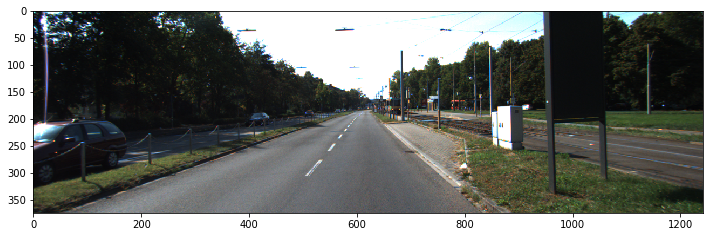

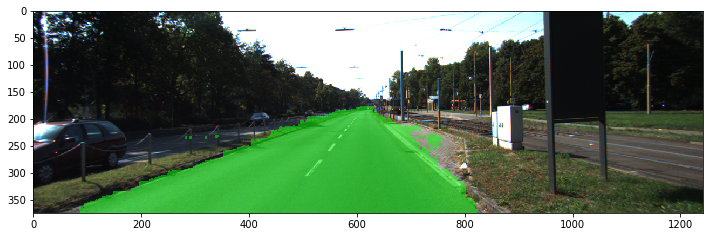

In [6]:
run_dir = "./runs"
test_dir = "./data/data_road/testing/image_2"

runs = [d for d in os.listdir(run_dir) if os.path.isdir(os.path.join(run_dir, d)) and d.startswith('Epochs')]

assert runs, "runs folder does not contain any saved models. Please run main.py and do training first."


# When sorted alphabetically by loss, the first should be the best one
model_dir = os.path.join(run_dir,sorted(runs)[0] +'/model')  

print(f"Loading model from {model_dir}")

with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(model_dir+'/model.meta')
    saver.restore(sess, tf.train.latest_checkpoint(model_dir))
  
    test_image = os.path.join(test_dir, 'um_000000.png')
    image_shape = (160, 576) 
    
    image = imageio.imread(test_image)
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    
    graph = tf.get_default_graph()
    image_tensor = graph.get_tensor_by_name("image_input:0")
    logits_tensor = graph.get_tensor_by_name("logits:0")
    keep_prob_tensor = graph.get_tensor_by_name("keep_prob:0")
    
    seg_img = apply_inference(sess, logits_tensor, keep_prob_tensor, image_tensor, image, image_shape)
    plt.figure(figsize=(12, 8))
    plt.imshow(seg_img) 
                              


Apply neural network to all test images and generate video

In [7]:
source_image_folder = "./data/data_road/testing/image_2"
video_name = 'video.mp4'

images = list([img for img in os.listdir(source_image_folder) if img.endswith(".png")])

assert images, "Source image folder must contain some PNG files"

frame = cv2.imread(os.path.join(source_image_folder, images[0]))
height, width, layers = frame.shape
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'MP4V'), 15, (width,height))

with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(model_dir+'/model.meta')
    saver.restore(sess, tf.train.latest_checkpoint(model_dir))
  
    test_image = os.path.join(test_dir, 'um_000000.png')
    image_shape = (160, 576) 
    
    graph = tf.get_default_graph()
    image_tensor = graph.get_tensor_by_name("image_input:0")
    logits_tensor = graph.get_tensor_by_name("logits:0")
    keep_prob_tensor = graph.get_tensor_by_name("keep_prob:0")
    
    for image_file in log_progress(sorted(images), every=1):
        image = imageio.imread(os.path.join(source_image_folder, image_file))
        seg_img = apply_inference(sess, logits_tensor, keep_prob_tensor, image_tensor, image, image_shape)
        video.write(seg_img)

    cv2.destroyAllWindows()
    video.release()


INFO:tensorflow:Restoring parameters from ./runs/Epochs10_Batch16_KeepProb0.5_LearnRate0.001_Loss0.115/model/model


In [8]:
%%HTML
<video width="621" height="188" controls>
  <source src="https://github.com/cazacov/CarND-Semantic-Segmentation/blob/master/video.mp4?raw=true" type="video/mp4">
</video>
